### Работа с текстовыми файлами: деление и подсчет и объединение

делю текстовый файл с человеческими текстами на файлы по 500, 1000, 5000, 10000, 15000, 20000, 25000 и 30000 слов.

В папке human сохранилось 6689 файлов

- bigmGPT - 470 файлов
- bigbalaboba - 968 файлов
- biggpt2 - 1161 файла
- newlstm - 1049 файлов

In [ ]:
# Подключаем Google Диск
from google.colab import drive
drive.mount('/content/drive')

import os
import random

# Путь к вашему файлу и папке на Google Диске
drive_root = "/content/drive/MyDrive/K_means/texts_for_classificator"
input_file = os.path.join(drive_root, "russian_newlstm_corpus.txt")
output_dir = os.path.join(drive_root, "newlstm_texts")

# Создаем папку, если её нет
os.makedirs(output_dir, exist_ok=True)

# Размеры сегментов (в словах)
chunk_sizes = [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000]

# Функция: сбалансированное распределение размеров
def get_balanced_sizes(total_words):
    sizes = []
    counts = {size: 0 for size in chunk_sizes}
    while total_words >= min(chunk_sizes):
        size = random.choice(chunk_sizes)
        if total_words >= size:
            sizes.append(size)
            counts[size] += 1
            total_words -= size
    return sizes

# Чтение исходного файла
with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()

words = text.split()
total_words = len(words)

# Получаем размеры сегментов
segment_sizes = get_balanced_sizes(total_words)

# Разделяем и сохраняем текст по сегментам
start = 0
for i, size in enumerate(segment_sizes):
    end = start + size
    chunk = words[start:end]
    filename = os.path.join(output_dir, f"part_{i+1:03d}.txt")
    with open(filename, "w", encoding="utf-8") as f:
        f.write(" ".join(chunk))
    start = end

print(f"✅ Успешно сохранено {len(segment_sizes)} файлов в папку: {output_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Успешно сохранено 1049 файлов в папку: /content/drive/MyDrive/K_means/texts_for_classificator/newlstm_texts


создаю корпусы с одинаковым количеством слов (20 тыс) в файлах

- newlit - 4439 файлов
- newlstm - 687 файлов
- bigmGPT - 317 файлов
- balaboba - 645 файлов
- biggpt2 - 789 файлов

In [ ]:
# Подключаем Google Диск
from google.colab import drive
drive.mount('/content/drive')

import os

# Путь к вашему файлу и папке на Google Диске
drive_root = "/content/drive/MyDrive/K_means/"
input_file = os.path.join(drive_root, "russian_biggpt2_corpus.txt")
output_dir = os.path.join(drive_root, "biggpt2_by_20k")

# Создаем папку, если её нет
os.makedirs(output_dir, exist_ok=True)

# Размер сегмента (в словах)
chunk_size = 20000

# Чтение исходного файла
with open(input_file, "r", encoding="utf-8") as f:
    text = f.read()

words = text.split()
total_words = len(words)
num_chunks = (total_words + chunk_size - 1) // chunk_size  # округляем вверх

# Разделяем и сохраняем текст по сегментам
for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, total_words)
    chunk = words[start:end]
    filename = os.path.join(output_dir, f"part_{i+1:03d}.txt")
    with open(filename, "w", encoding="utf-8") as f:
        f.write(" ".join(chunk))

print(f"✅ Успешно сохранено {num_chunks} файлов в папку: {output_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Успешно сохранено 789 файлов в папку: /content/drive/MyDrive/K_means/biggpt2_by_20k


разделила данные на тренировочные и тестовые папки, в каждой из которых хранятся три файла: human + 2 bot

- Train human: 3347
- Test human: 3347
- Train bots (['biggpt2', 'newlstm']): 2210
- Test bots (['bigmGPT', 'bigbalaboba']): 1438

In [ ]:
import os
import random
import shutil
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

# Параметры
random.seed(42)
data_dir = Path("/content/drive/MyDrive/K_means/equal_files_20000")      # исходная папка с human/, gpt2/, mgpt/ и т.д.
output_dir = Path("/content/drive/MyDrive/K_means/split_20")   # куда сохраняются train/ и test/
output_dir.mkdir(exist_ok=True)

# Бот-модели
all_bot_models = ["bigmGPT_by_20k", "balaboba_by_20k", "biggpt2_by_20k", "newlstm_by_20k"]

# 1. Получаем human-тексты и делим
human_files = list((data_dir / "human_by_20k").rglob("*.txt"))
random.shuffle(human_files)
split_idx = len(human_files) // 2
train_human = human_files[:split_idx]
test_human = human_files[split_idx:]

# 2. Делим ботов на train/test модели
bot_models = all_bot_models.copy()
random.shuffle(bot_models)
train_bot_models = bot_models[:2]
test_bot_models = bot_models[2:]

# 3. Получаем файлы ботов
def get_bot_files(model_names):
    files = []
    for model in model_names:
        files += list((data_dir / model).rglob("*.txt"))
    return files

train_bot = get_bot_files(train_bot_models)
test_bot = get_bot_files(test_bot_models)

# 4. Функция копирования файлов в нужную папку
def copy_files(files, subset: str, label: str):
    """
    subset: 'train_20' или 'test_20'
    label: 'human', 'gpt2', 'mgpt', и т.п.
    """
    subset_dir = output_dir / subset / label
    subset_dir.mkdir(parents=True, exist_ok=True)
    for src_file in files:
        dest_file = subset_dir / src_file.name
        shutil.copy2(src_file, dest_file)

# 5. Копируем файлы
copy_files(train_human, "train_20", "human_by_20k")
copy_files(test_human, "test_20", "human_by_20k")
for model in train_bot_models:
    model_files = list((data_dir / model).rglob("*.txt"))
    copy_files(model_files, "train_20", model)

for model in test_bot_models:
    model_files = list((data_dir / model).rglob("*.txt"))
    copy_files(model_files, "test_20", model)

# 6. Печать инфо
print(f"Train human: {len(train_human)}")
print(f"Test human: {len(test_human)}")
print(f"Train bots ({train_bot_models}): {len(train_bot)}")
print(f"Test bots ({test_bot_models}): {len(test_bot)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train human: 2219
Test human: 2220
Train bots (['bigmGPT_by_20k', 'biggpt2_by_20k']): 1106
Test bots (['balaboba_by_20k', 'newlstm_by_20k']): 1332


### реализую метрику CVNN (Оценивает разделение на основе геометрического расположения точек в кластерах, используя динамические представления для различных кластеров)

In [ ]:
import numpy as np
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors

class CVNNValidator:
    def __init__(self, k_neighbors=5):
        self.k = max(1, k_neighbors)  # Гарантируем хотя бы 1 соседа

    def compute_index(self, data, labels):
        unique_labels, counts = np.unique(labels, return_counts=True)
        n_clusters = len(unique_labels)

        # Краевые случаи
        if n_clusters == 1 or len(data) < 2:
            return float('inf')

        # Отсеиваем шумовые точки (метка -1)
        valid_mask = labels != -1
        data = data[valid_mask]
        labels = labels[valid_mask]

        total_compactness = 0.0
        total_separability = 0.0
        valid_clusters = 0

        for label in unique_labels:
            if label == -1:
                continue

            cluster_points = data[labels == label]
            other_points = data[labels != label]

            if len(cluster_points) < 2:
                continue

            # Компактность
            pairwise_dist = distance.pdist(cluster_points)
            compactness = np.mean(pairwise_dist)

            # Разделимость
            if len(other_points) > 0:
                n_neighbors = min(self.k, len(other_points))
                nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(other_points)
                distances, _ = nbrs.kneighbors(cluster_points)
                separability = np.mean(distances)
            else:
                separability = 0.0

            total_compactness += compactness
            total_separability += separability
            valid_clusters += 1

        if valid_clusters == 0 or total_separability == 0:
            return float('inf')

        # Финальная формула
        raw_score = (total_compactness / valid_clusters) / (total_separability / valid_clusters)
        return 1 - np.exp(-raw_score)

### метрика s_dbw

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

def S_Dbw(X, labels, centers=None, k_neighbors=5):
    """
    Вычисляет Score Density-based (S_Dbw) для оценки кластеризации.

    Параметры:
        X : array-like, shape (n_samples, n_features)
            Входные данные.
        labels : array-like, shape (n_samples,)
            Метки кластеров.
        centers : array-like, shape (n_clusters, n_features), optional
            Центры кластеров. Если None, будут вычислены как средние.
        k_neighbors : int, optional
            Количество соседей для оценки плотности.

    Возвращает:
        s_dbw : float
            Значение метрики S_Dbw (чем меньше, тем лучше).
    """
    # Проверка входных данных
    if len(X) != len(labels):
        raise ValueError("Размеры X и labels должны совпадать")

    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    n_samples, n_features = X.shape

    # Если только один кластер, возвращаем плохое значение
    if n_clusters < 2:
        return float('inf')

    # Вычисляем центры кластеров, если не предоставлены
    if centers is None:
        centers = np.array([X[labels == k].mean(axis=0) for k in unique_labels])

    # 1. Вычисляем Scat (компактность)
    scat = 0.0
    sigma = np.zeros(n_features)

    for k in unique_labels:
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            sigma += np.std(cluster_points, axis=0) ** 2

    sigma = np.sqrt(sigma / n_clusters)
    scat = np.linalg.norm(sigma) / (np.linalg.norm(np.std(X, axis=0)) * np.sqrt(n_clusters))

    # 2. Вычисляем Dens_bw (разделимость)
    dens_bw = 0.0
    stdev = np.mean(np.std(X, axis=0))

    # Находим все пары кластеров
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            # Точка посередине между центрами кластеров
            u_ij = (centers[i] + centers[j]) / 2

            # Плотность в точке u_ij
            dist_to_u = cdist(X, [u_ij])
            radius = stdev / 2
            points_in_radius = np.sum(dist_to_u <= radius)

            # Плотность в кластерах i и j
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]

            if len(cluster_i) > 0:
                dist_i = cdist(cluster_i, [centers[i]])
                dens_i = np.sum(dist_i <= radius)
                dens_i = dens_i / len(cluster_i) if len(cluster_i) > 0 else 0
            else:
                dens_i = 0

            if len(cluster_j) > 0:
                dist_j = cdist(cluster_j, [centers[j]])
                dens_j = np.sum(dist_j <= radius)
                dens_j = dens_j / len(cluster_j) if len(cluster_j) > 0 else 0
            else:
                dens_j = 0

            # Максимальная плотность между двумя кластерами
            max_dens = max(dens_i, dens_j)

            if max_dens != 0:
                dens_bw += points_in_radius / max_dens
    # Нормализация
    n_pairs = n_clusters * (n_clusters - 1) / 2
    dens_bw = dens_bw / n_pairs if n_pairs > 0 else 0

    # Финальный показатель
    s_dbw = scat + dens_bw

    return s_dbw

In [ ]:
!pip install kneed
!pip install s_dbw

### K-means with PCA + внешние метрики

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from matplotlib.colors import ListedColormap
from kneed import KneeLocator
import numpy as np
import os
from tqdm.auto import tqdm
import gc
import pandas as pd
from google.colab import drive
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.utils import resample
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist

class BatchTextProcessor:
    def __init__(self, dict_path, batch_size=10000):
        self.wdict = np.load(dict_path, allow_pickle=True).item()
        self.batch_size = batch_size
        self.cvnn_validator = CVNNValidator(k_neighbors=5)

    def _apply_pca(self, X, n_components=25):
        if X.shape[1] <= n_components:
            return X
        pca = PCA(n_components=n_components, random_state=42)
        return pca.fit_transform(X)

    def _find_optimal_k(self, X_n, max_k=10, n_init=3, stability_checks=3):
        """
        Улучшенный метод определения оптимального числа кластеров:
        1. Использует KneeLocator для точного нахождения "локтя"
        2. Комбинирует с Silhouette Score и SDbw
        3. Проверяет стабильность кластеров
        """
        # Инициализация
        distortions = []
        silhouette_scores = []
        sdbw_scores = []
        K_range = range(2, max_k + 1)

        # Вычисление метрик для каждого k
        for k in K_range:
            kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=123)
            kmeans.fit(X_n)
            labels = kmeans.labels_
            distortions.append(kmeans.inertia_)

            if k > 1:  # Silhouette требует минимум 2 кластера
                silhouette_scores.append(silhouette_score(X_n, labels))
                sdbw_scores.append(S_Dbw(X_n, labels))

        # 1. Автоматическое определение "локтя" через KneeLocator
        kneedle = KneeLocator(
            K_range,
            distortions,
            curve='convex',
            direction='decreasing'
        )
        optimal_k_elbow = kneedle.elbow if kneedle.elbow else 3  # fallback

        # 2. Оптимальное k по Silhouette Score
        optimal_k_sil = np.argmax(silhouette_scores) + 2 if silhouette_scores else optimal_k_elbow

        # 3. Оптимальное k по SDbw (минимизируем)
        optimal_k_sdbw = np.argmin(sdbw_scores) + 2 if sdbw_scores else optimal_k_elbow

        # 4. Комбинированный результат (берем медиану)
        combined_k = int(np.median([optimal_k_elbow, optimal_k_sil, optimal_k_sdbw]))

        # 5. Проверка стабильности (опционально)
        if stability_checks > 1:
            stability = self._check_cluster_stability(X_n, combined_k, n_iter=stability_checks)
            if stability > 0.1 * distortions[combined_k-2]:  # Если разброс >10% от inertia
                combined_k = max(optimal_k_elbow, optimal_k_sil - 1)  # Уменьшаем k

        return int(min(combined_k, max_k))

    def _check_cluster_stability(self, X_n, k, n_iter=5):
        """Проверяет стабильность кластеров через бутстрап"""
        inertia_values = []
        for _ in range(n_iter):
            X_resampled = resample(X_n, replace=True, n_samples=len(X_n))
            kmeans = KMeans(n_clusters=k, n_init=1).fit(X_resampled)
            inertia_values.append(kmeans.inertia_)
        return np.std(inertia_values)

    def _calculate_cluster_metrics(self, X_n, labels):
        """Вычисляет все метрики кластеризации для текущего батча"""
        metrics = {}
        n_clusters = len(np.unique(labels))

        # Инициализация валидатора CVNN
        cvnn_validator = CVNNValidator(k_neighbors=5)

        # Общие метрики для всех случаев
        metrics.update({
            'silhouette': -1 if n_clusters < 2 else silhouette_score(X_n, labels),
            'davies_bouldin': float('inf') if n_clusters < 2 else davies_bouldin_score(X_n, labels),
            'sdbw': float('inf') if n_clusters < 2 else S_Dbw(X_n, labels),
            'cvnn': cvnn_validator.compute_index(X_n, labels)  # Всегда вычисляем, так как метод сам обрабатывает краевые случаи
        })

        return metrics

    def _calculate_inter_cluster_metrics(self, kmeans):
        """Вычисляет расстояния между центроидами кластеров"""
        centroids = kmeans.cluster_centers_
        if len(centroids) < 2:
            return {'min_inter': 0.0, 'max_inter': 0.0, 'mean_inter': 0.0}

        centroid_distances = pdist(centroids, metric='euclidean')
        return {
            'min_inter': np.min(centroid_distances),
            'max_inter': np.max(centroid_distances),
            'mean_inter': np.mean(centroid_distances)
        }


    def _handle_small_last_batch(self, batch_files, n):
        if len(batch_files) == 1:
            raise ValueError(f"Недостаточно данных. Нужно минимум {n} слов, а получено {len(np.load(batch_files[0], allow_pickle=True))}")

        last_batch = np.load(batch_files.pop(), allow_pickle=True)
        prev_batch = np.load(batch_files[-1], allow_pickle=True)
        combined = np.vstack((prev_batch, last_batch))
        np.save(batch_files[-1], combined)

        print(f"Объединены последние пакеты. Новый размер: {len(combined)}")
        return batch_files

    def _create_batches(self, file_path, temp_dir):
        batch_files = []
        with open(file_path, 'r', encoding='utf-8') as f:
            words = []
            for line in f:
                words.extend(line.split())
                if len(words) >= self.batch_size:
                    batch_file = os.path.join(temp_dir, f"batch_{len(batch_files)}.npy")
                    self._save_batch(words[:self.batch_size], batch_file)
                    batch_files.append(batch_file)
                    words = words[self.batch_size:]
                    gc.collect()

        if words:
            batch_file = os.path.join(temp_dir, f"batch_{len(batch_files)}.npy")
            self._save_batch(words, batch_file)
            batch_files.append(batch_file)

        return batch_files

    def _save_batch(self, words, batch_file):
        embs = [self.wdict[w] for w in words if w in self.wdict]
        if embs:
            np.save(batch_file, np.vstack(embs))


    def get_ngram_stats(self, batch_files, n):
        """Печатает статистику по n-граммам"""
        total_ngrams = 0
        unique_ngrams = set()

        for batch_file in tqdm(batch_files, desc=f"Анализ {n}-грамм"):  # Исправлено здесь
            batch = np.load(batch_file, allow_pickle=True)
            if len(batch) >= n:
                for i in range(len(batch) - n + 1):
                    ngram = tuple(batch[i:i+n].flatten())
                    unique_ngrams.add(ngram)
                    total_ngrams += 1

        uniqueness_ratio = len(unique_ngrams)/total_ngrams if total_ngrams > 0 else 0

        print(f"\n📊 Итоговая статистика {n}-грамм:")  # Здесь n берется из параметров метода
        print(f"Общее количество {n}-грамм: {total_ngrams}")  # Добавлено n для ясности
        print(f"Количество уникальных {n}-грамм: {len(unique_ngrams)}")
        print(f"Коэффициент уникальности: {uniqueness_ratio:.2%}")

        return total_ngrams, len(unique_ngrams), uniqueness_ratio

    def _process_batches(self, batch_files, n, k, temp_dir, start_idx, all_stats):
        use_minibatch = len(batch_files) * self.batch_size > 100000

        # Автоматическое определение k для первого батча
        if isinstance(k, str) and k == 'auto':
            first_batch = np.load(batch_files[0], allow_pickle=True)
            X_n_sample = self._create_ngrams(first_batch, n)
            if X_n_sample is not None:
                k = self._find_optimal_k(X_n_sample)
                print(f"Автоматически определено оптимальное k = {k}")
            else:
                k = 5
                print(f"Не удалось определить оптимальное k, использую k = {k}")

        if not isinstance(k, int) or k < 1:
            raise ValueError(f"Количество кластеров должно быть положительным целым числом. Получено: {k}")

        kmeans = MiniBatchKMeans(n_clusters=k, random_state=123, batch_size=self.batch_size) if use_minibatch \
            else KMeans(n_clusters=k, init='k-means++', n_init=1, random_state=123)

        with tqdm(total=len(batch_files) * 2, desc="Общая прогрессия") as main_pbar:
            X_all = []
            # Фаза обучения
            for idx, batch_file in enumerate(batch_files[start_idx:]):
                try:
                    batch = np.load(batch_file, allow_pickle=True)
                    X_n = self._create_ngrams(batch, n)

                    if X_n is not None:
                        if use_minibatch:
                            kmeans.partial_fit(X_n)
                        else:
                            X_all.append(X_n)
                except Exception as e:
                    print(f"Ошибка при обработке батча {idx}: {str(e)}")
                    continue

                main_pbar.update(1)
                main_pbar.set_postfix({"фаза": "обучение"})
                gc.collect()

            if not use_minibatch and X_all:
                X_all = np.vstack(X_all)
                kmeans.fit(X_all)
                del X_all
                gc.collect()

            # Фаза предсказания
            all_stats = []
            for idx, batch_file in enumerate(batch_files[start_idx:]):
                try:
                    batch = np.load(batch_file, allow_pickle=True)
                    X_n = self._create_ngrams(batch, n)

                    if X_n is not None:
                        labels = kmeans.predict(X_n)
                        stats = self._calculate_stats(X_n, labels, k)
                        all_stats.append(stats)
                except Exception as e:
                    print(f"Ошибка при предсказании для батча {idx}: {str(e)}")
                    continue

                main_pbar.update(1)
                main_pbar.set_postfix({"фаза": "предсказание"})
                gc.collect()

        return self._aggregate_stats(all_stats)

    def _create_ngrams(self, data, n):
        if len(data) < n:
            return None
        try:
            ngrams = np.concatenate([data[i:len(data)-n+i] for i in range(n)], axis=1)
            unique_ngrams = np.unique(ngrams, axis=0)
            return unique_ngrams
        except:
            return None

    def _calculate_stats(self, X_n, labels, k):
        X_dist = pdist(X_n)
        stats = {
            'mean': [],
            'min': [],
            'max': [],
            'counts': np.zeros(k),
            'metrics': self._calculate_cluster_metrics(X_n, labels)
        }

        # Внутрикластерные расстояния
        for c in range(k):
            cluster_idx = np.where(labels == c)[0]
            if len(cluster_idx) > 1:
                mean, min1, max1 = cluster_distances(X_dist, cluster_idx, len(X_n))
                stats['mean'].append(mean)
                stats['min'].append(min1)
                stats['max'].append(max1)
            stats['counts'][c] += len(cluster_idx)

        # Межкластерные расстояния (используем сохранённый kmeans)
        if hasattr(self, 'kmeans') and self.kmeans is not None:
            inter_metrics = self._calculate_inter_cluster_metrics(self.kmeans)
            stats.update(inter_metrics)  # Добавляем min_inter, max_inter, mean_inter напрямую в stats
        else:
            stats.update({'min_inter': 0.0, 'max_inter': 0.0, 'mean_inter': 0.0})

        return stats

    def _aggregate_stats(self, all_stats):
        if not all_stats:
            return {
                'mean_icd': 0.0,
                'min_icd': 0.0,
                'max_icd': 0.0,
                'min_inter': 0.0,
                'max_inter': 0.0,
                'mean_inter': 0.0,
                'cluster_distribution': [],
                'silhouette': 0.0,
                'davies_bouldin': 0.0,
                'sdbw': 0.0,
                'cvnn': 0.0,
                'uniqueness_ratio': 0.0
            }

        # Средние значения для внутрикластерных метрик
        mean_icd = np.mean([np.mean(s['mean']) for s in all_stats if s.get('mean')]) if any(s.get('mean') for s in all_stats) else 0.0
        min_icd = np.mean([np.mean(s['min']) for s in all_stats if s.get('min')]) if any(s.get('min') for s in all_stats) else 0.0
        max_icd = np.mean([np.mean(s['max']) for s in all_stats if s.get('max')]) if any(s.get('max') for s in all_stats) else 0.0

        # Средние значения для межкластерных метрик (теперь они уже в корне stats, а не в inter_metrics)
        min_inter = np.mean([s.get('min_inter', 0.0) for s in all_stats])
        max_inter = np.mean([s.get('max_inter', 0.0) for s in all_stats])
        mean_inter = np.mean([s.get('mean_inter', 0.0) for s in all_stats])

        # Остальные метрики
        silhouette = np.mean([s['metrics']['silhouette'] for s in all_stats])
        davies_bouldin = np.mean([s['metrics']['davies_bouldin'] for s in all_stats])
        sdbw = np.mean([s['metrics']['sdbw'] for s in all_stats])
        cvnn = np.mean([s['metrics']['cvnn'] for s in all_stats])

        cluster_counts = np.zeros_like(all_stats[0]['counts']) if 'counts' in all_stats[0] else np.zeros(self.k)

        for s in all_stats:
            if 'counts' in s:
                cluster_counts += s['counts']

        return {
            'mean_icd': mean_icd,
            'min_icd': min_icd,
            'max_icd': max_icd,
            'min_inter': min_inter,
            'max_inter': max_inter,
            'mean_inter': mean_inter,
            'cluster_distribution': cluster_counts.tolist(),
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'sdbw': sdbw,
            'cvnn': cvnn,
            'uniqueness_ratio': all_stats[0].get('uniqueness_ratio', 0.0) if all_stats else 0.0
        }
    def _cleanup(self, temp_dir):
        # Не удаляем временные батчи, чтобы не потерять данные при перезапуске
        pass


    def process_text(self, file_path, n, k):
        temp_dir = "./temp_batches/"
        os.makedirs(temp_dir, exist_ok=True)
        try:
            batch_files = self._create_batches(file_path, temp_dir)
            total_ngrams, unique_ngrams, uniqueness_ratio = self.get_ngram_stats(batch_files, n)
            all_stats = []
            for batch_file in batch_files:
                try:
                    batch = np.load(batch_file, allow_pickle=True)
                    X_n = self._create_ngrams(batch, n)
                    if X_n is not None:
                        X_n = self._apply_pca(X_n, n_components=25)
                        if k == 'auto':
                            k = self._find_optimal_k(X_n)
                        self.kmeans = KMeans(n_clusters=k, random_state=42)
                        labels = self.kmeans.fit_predict(X_n)
                        stats = self._calculate_stats(X_n, labels, k)
                        stats['uniqueness_ratio'] = uniqueness_ratio
                        all_stats.append(stats)
                except Exception as e:
                    print(f"⚠️ Ошибка при обработке батча {batch_file}: {str(e)}")
                    continue
            if not all_stats:
                raise ValueError("Не удалось обработать ни один батч")
            return self._aggregate_stats(all_stats)
        finally:
            self._cleanup(temp_dir)

    def process_text_pca25(self, file_path, n, k):
        return self.process_text(file_path, n, k)


def cluster_distances(X_dist, cluster_idx, n_max):
    d = X_dist[get_dist_idx(cluster_idx, n_max)]
    if len(d) == 0:
        return 0.0, 0.0, 0.0
    return d.mean(), d.min(), d.max()

def get_dist_idx(idx, n_max=1000):
    idx = sorted(idx)
    return [n_max * idx[ii] + idx[jj] - ((idx[ii] + 2) * (idx[ii] + 1)) // 2
            for ii in range(len(idx)) for jj in range(ii + 1, len(idx))]

def process_and_cluster_files():
    print("⏳ Монтирую Google Drive...")
    drive.mount('/content/drive')
    print("✅ Google Drive смонтирован")

    BASE_PATH = '/content/drive/MyDrive/K_means/split_20/train_20'
    SPLIT_DIR = os.path.join(BASE_PATH, 'human_by_20k')
    OUTPUT_CSV = os.path.join(BASE_PATH, 'metrics_human_train_pca_20.csv')
    TEMP_CSV = os.path.join(BASE_PATH, 'temp_metrics.csv')

    if not os.path.exists(SPLIT_DIR):
        raise FileNotFoundError(f"Папка с разделенными текстами не найдена: {SPLIT_DIR}")

    params = {
        'n': 1,
        'k': 'auto',
        'batch_size': 10000
    }

    processor = BatchTextProcessor(
        dict_path=os.path.join(BASE_PATH, "ru_cbow_dictionary.npy"),
        batch_size=params['batch_size']
    )

    if os.path.exists(OUTPUT_CSV):
        existing_df = pd.read_csv(OUTPUT_CSV)
        processed_files = set(existing_df['filename']) if not existing_df.empty else set()
        print(f"\n📂 Найдено {len(existing_df)} предыдущих записей в файле {OUTPUT_CSV}")
    else:
        existing_df = pd.DataFrame()
        processed_files = set()
        print("\n🆕 Файл с результатами не найден, создаем новый")

    all_text_files = sorted(
        [f for f in os.listdir(SPLIT_DIR) if f.endswith('.txt')],
        key=lambda x: int(x.split('_')[1].split('.')[0]) if not x.startswith('full_text') else 0
    )

    text_files = [f for f in all_text_files if f not in processed_files]

    if not text_files:
        print("\nℹ️ Все файлы уже обработаны ранее. Новых файлов для обработки нет.")
        return

    print(f"\n🔍 Найдено {len(text_files)} файлов для обработки")

    if os.path.exists(TEMP_CSV):
        temp_df = pd.read_csv(TEMP_CSV)
    else:
        temp_df = pd.DataFrame()

    for i, text_file in enumerate(text_files, 1):
        file_path = os.path.join(SPLIT_DIR, text_file)
        print(f"\n🚀 Обрабатываю файл {i}/{len(text_files)}: {text_file}")

        try:
            text_id = os.path.basename(os.path.dirname(file_path))

            results = processor.process_text_pca25(
                file_path=file_path,
                n=params['n'],
                k=params['k']
            )

            new_row = {
                'text_id': text_id,
                'filename': text_file,
                'mean_icd': results['mean_icd'],
                'min_icd': results['min_icd'],
                'max_icd': results['max_icd'],
                'min_inter': results.get('min_inter', 0.0),
                'max_inter': results.get('max_inter', 0.0),
                'mean_inter': results.get('mean_inter', 0.0),
                'silhouette': results.get('silhouette', -1),
                'davies_bouldin': results.get('davies_bouldin', float('inf')),
                'sdbw': results.get('sdbw', float('inf')),
                'cvnn': results.get('cvnn', float('inf')),
                'uniqueness_ratio': results.get('uniqueness_ratio', 0),
                'total_clusters': len(results['cluster_distribution']),
                'cluster_distribution': str(results['cluster_distribution']),
                'human': 1,
                'bot': 0
            }

            temp_df = pd.concat([temp_df, pd.DataFrame([new_row])], ignore_index=True)
            temp_df.to_csv(TEMP_CSV, index=False)
            print(f"💾 Промежуточные результаты сохранены в {TEMP_CSV}")

            existing_df = pd.concat([existing_df, pd.DataFrame([new_row])], ignore_index=True)
            print(f"✅ Файл обработан. Всего записей: {len(existing_df)}")

        except Exception as e:
            print(f"⚠️ Ошибка при обработке файла {text_file}: {str(e)}")
            temp_df.to_csv(TEMP_CSV, index=False)
            continue

    existing_df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n💾 Все метрики сохранены в: {OUTPUT_CSV}")

    if os.path.exists(TEMP_CSV):
        os.remove(TEMP_CSV)
        print("Временный файл удален")

    print("\n📊 Итоговые метрики кластеризации:")
    if not existing_df.empty:
        print(existing_df.describe())
    else:
        print("Нет данных для отображения")

if __name__ == '__main__':
  process_and_cluster_files()

⏳ Монтирую Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive смонтирован

🆕 Файл с результатами не найден, создаем новый

🔍 Найдено 2219 файлов для обработки

🚀 Обрабатываю файл 1/2219: part_001.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10021
Количество уникальных 1-грамм: 3823
Коэффициент уникальности: 38.15%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 1

🚀 Обрабатываю файл 2/2219: part_007.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10197
Количество уникальных 1-грамм: 3520
Коэффициент уникальности: 34.52%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 2

🚀 Обрабатываю файл 3/2219: part_009.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9280
Количество уникальных 1-грамм: 3417
Коэффициент уникальности: 36.82%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 3

🚀 Обрабатываю файл 4/2219: part_010.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9372
Количество уникальных 1-грамм: 3479
Коэффициент уникальности: 37.12%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 4

🚀 Обрабатываю файл 5/2219: part_011.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9041
Количество уникальных 1-грамм: 3381
Коэффициент уникальности: 37.40%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 5

🚀 Обрабатываю файл 6/2219: part_013.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10754
Количество уникальных 1-грамм: 3519
Коэффициент уникальности: 32.72%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 6

🚀 Обрабатываю файл 7/2219: part_014.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9586
Количество уникальных 1-грамм: 3243
Коэффициент уникальности: 33.83%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 7

🚀 Обрабатываю файл 8/2219: part_015.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9774
Количество уникальных 1-грамм: 3184
Коэффициент уникальности: 32.58%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 8

🚀 Обрабатываю файл 9/2219: part_016.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9509
Количество уникальных 1-грамм: 3332
Коэффициент уникальности: 35.04%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 9

🚀 Обрабатываю файл 10/2219: part_018.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9563
Количество уникальных 1-грамм: 2924
Коэффициент уникальности: 30.58%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 10

🚀 Обрабатываю файл 11/2219: part_023.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 7835
Количество уникальных 1-грамм: 2730
Коэффициент уникальности: 34.84%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 11

🚀 Обрабатываю файл 12/2219: part_025.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9931
Количество уникальных 1-грамм: 3213
Коэффициент уникальности: 32.35%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 12

🚀 Обрабатываю файл 13/2219: part_026.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9570
Количество уникальных 1-грамм: 2943
Коэффициент уникальности: 30.75%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 13

🚀 Обрабатываю файл 14/2219: part_031.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8722
Количество уникальных 1-грамм: 2583
Коэффициент уникальности: 29.61%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 14

🚀 Обрабатываю файл 15/2219: part_033.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8598
Количество уникальных 1-грамм: 2527
Коэффициент уникальности: 29.39%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 15

🚀 Обрабатываю файл 16/2219: part_034.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8903
Количество уникальных 1-грамм: 3144
Коэффициент уникальности: 35.31%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 16

🚀 Обрабатываю файл 17/2219: part_035.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8032
Количество уникальных 1-грамм: 2451
Коэффициент уникальности: 30.52%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 17

🚀 Обрабатываю файл 18/2219: part_036.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9959
Количество уникальных 1-грамм: 3435
Коэффициент уникальности: 34.49%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 18

🚀 Обрабатываю файл 19/2219: part_037.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10074
Количество уникальных 1-грамм: 3557
Коэффициент уникальности: 35.31%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 19

🚀 Обрабатываю файл 20/2219: part_040.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8959
Количество уникальных 1-грамм: 2392
Коэффициент уникальности: 26.70%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 20

🚀 Обрабатываю файл 21/2219: part_041.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9906
Количество уникальных 1-грамм: 3064
Коэффициент уникальности: 30.93%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 21

🚀 Обрабатываю файл 22/2219: part_045.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10312
Количество уникальных 1-грамм: 3614
Коэффициент уникальности: 35.05%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 22

🚀 Обрабатываю файл 23/2219: part_046.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10346
Количество уникальных 1-грамм: 3378
Коэффициент уникальности: 32.65%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 23

🚀 Обрабатываю файл 24/2219: part_047.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10314
Количество уникальных 1-грамм: 3522
Коэффициент уникальности: 34.15%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 24

🚀 Обрабатываю файл 25/2219: part_049.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10554
Количество уникальных 1-грамм: 3827
Коэффициент уникальности: 36.26%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 25

🚀 Обрабатываю файл 26/2219: part_052.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8869
Количество уникальных 1-грамм: 2511
Коэффициент уникальности: 28.31%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 26

🚀 Обрабатываю файл 27/2219: part_053.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10156
Количество уникальных 1-грамм: 3613
Коэффициент уникальности: 35.58%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 27

🚀 Обрабатываю файл 28/2219: part_054.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9741
Количество уникальных 1-грамм: 3349
Коэффициент уникальности: 34.38%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 28

🚀 Обрабатываю файл 29/2219: part_055.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9309
Количество уникальных 1-грамм: 3297
Коэффициент уникальности: 35.42%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 29

🚀 Обрабатываю файл 30/2219: part_057.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 6689
Количество уникальных 1-грамм: 2373
Коэффициент уникальности: 35.48%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 30

🚀 Обрабатываю файл 31/2219: part_058.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 5540
Количество уникальных 1-грамм: 1789
Коэффициент уникальности: 32.29%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 31

🚀 Обрабатываю файл 32/2219: part_060.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 5779
Количество уникальных 1-грамм: 1850
Коэффициент уникальности: 32.01%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 32

🚀 Обрабатываю файл 33/2219: part_061.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 6698
Количество уникальных 1-грамм: 2262
Коэффициент уникальности: 33.77%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 33

🚀 Обрабатываю файл 34/2219: part_063.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9697
Количество уникальных 1-грамм: 2049
Коэффициент уникальности: 21.13%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 34

🚀 Обрабатываю файл 35/2219: part_064.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10115
Количество уникальных 1-грамм: 1577
Коэффициент уникальности: 15.59%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 35

🚀 Обрабатываю файл 36/2219: part_065.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 7570
Количество уникальных 1-грамм: 2847
Коэффициент уникальности: 37.61%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 36

🚀 Обрабатываю файл 37/2219: part_066.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10337
Количество уникальных 1-грамм: 3481
Коэффициент уникальности: 33.68%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 37

🚀 Обрабатываю файл 38/2219: part_067.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9813
Количество уникальных 1-грамм: 3370
Коэффициент уникальности: 34.34%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 38

🚀 Обрабатываю файл 39/2219: part_069.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10793
Количество уникальных 1-грамм: 3882
Коэффициент уникальности: 35.97%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 39

🚀 Обрабатываю файл 40/2219: part_070.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10337
Количество уникальных 1-грамм: 3705
Коэффициент уникальности: 35.84%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 40

🚀 Обрабатываю файл 41/2219: part_071.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9963
Количество уникальных 1-грамм: 3425
Коэффициент уникальности: 34.38%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 41

🚀 Обрабатываю файл 42/2219: part_072.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9704
Количество уникальных 1-грамм: 2702
Коэффициент уникальности: 27.84%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 42

🚀 Обрабатываю файл 43/2219: part_073.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9691
Количество уникальных 1-грамм: 3137
Коэффициент уникальности: 32.37%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 43

🚀 Обрабатываю файл 44/2219: part_075.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10348
Количество уникальных 1-грамм: 3017
Коэффициент уникальности: 29.16%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 44

🚀 Обрабатываю файл 45/2219: part_076.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10044
Количество уникальных 1-грамм: 3033
Коэффициент уникальности: 30.20%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 45

🚀 Обрабатываю файл 46/2219: part_077.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10188
Количество уникальных 1-грамм: 3209
Коэффициент уникальности: 31.50%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 46

🚀 Обрабатываю файл 47/2219: part_079.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9694
Количество уникальных 1-грамм: 3119
Коэффициент уникальности: 32.17%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 47

🚀 Обрабатываю файл 48/2219: part_080.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9903
Количество уникальных 1-грамм: 2703
Коэффициент уникальности: 27.29%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 48

🚀 Обрабатываю файл 49/2219: part_081.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9320
Количество уникальных 1-грамм: 3112
Коэффициент уникальности: 33.39%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 49

🚀 Обрабатываю файл 50/2219: part_082.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8980
Количество уникальных 1-грамм: 2914
Коэффициент уникальности: 32.45%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 50

🚀 Обрабатываю файл 51/2219: part_083.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9026
Количество уникальных 1-грамм: 3075
Коэффициент уникальности: 34.07%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 51

🚀 Обрабатываю файл 52/2219: part_084.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9182
Количество уникальных 1-грамм: 3206
Коэффициент уникальности: 34.92%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 52

🚀 Обрабатываю файл 53/2219: part_087.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9902
Количество уникальных 1-грамм: 3474
Коэффициент уникальности: 35.08%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 53

🚀 Обрабатываю файл 54/2219: part_091.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9404
Количество уникальных 1-грамм: 3322
Коэффициент уникальности: 35.33%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 54

🚀 Обрабатываю файл 55/2219: part_094.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9103
Количество уникальных 1-грамм: 2925
Коэффициент уникальности: 32.13%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 55

🚀 Обрабатываю файл 56/2219: part_096.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10640
Количество уникальных 1-грамм: 3593
Коэффициент уникальности: 33.77%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 56

🚀 Обрабатываю файл 57/2219: part_097.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10390
Количество уникальных 1-грамм: 3378
Коэффициент уникальности: 32.51%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 57

🚀 Обрабатываю файл 58/2219: part_098.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9988
Количество уникальных 1-грамм: 3594
Коэффициент уникальности: 35.98%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 58

🚀 Обрабатываю файл 59/2219: part_102.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8597
Количество уникальных 1-грамм: 2900
Коэффициент уникальности: 33.73%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 59

🚀 Обрабатываю файл 60/2219: part_112.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8050
Количество уникальных 1-грамм: 2940
Коэффициент уникальности: 36.52%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 60

🚀 Обрабатываю файл 61/2219: part_115.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9129
Количество уникальных 1-грамм: 2934
Коэффициент уникальности: 32.14%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 61

🚀 Обрабатываю файл 62/2219: part_116.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9003
Количество уникальных 1-грамм: 1798
Коэффициент уникальности: 19.97%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 62

🚀 Обрабатываю файл 63/2219: part_117.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9716
Количество уникальных 1-грамм: 2142
Коэффициент уникальности: 22.05%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 63

🚀 Обрабатываю файл 64/2219: part_118.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9833
Количество уникальных 1-грамм: 2296
Коэффициент уникальности: 23.35%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 64

🚀 Обрабатываю файл 65/2219: part_119.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9645
Количество уникальных 1-грамм: 1979
Коэффициент уникальности: 20.52%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 65

🚀 Обрабатываю файл 66/2219: part_121.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8622
Количество уникальных 1-грамм: 2927
Коэффициент уникальности: 33.95%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 66

🚀 Обрабатываю файл 67/2219: part_123.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9497
Количество уникальных 1-грамм: 3133
Коэффициент уникальности: 32.99%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 67

🚀 Обрабатываю файл 68/2219: part_125.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9476
Количество уникальных 1-грамм: 3287
Коэффициент уникальности: 34.69%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 68

🚀 Обрабатываю файл 69/2219: part_126.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10849
Количество уникальных 1-грамм: 3695
Коэффициент уникальности: 34.06%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 69

🚀 Обрабатываю файл 70/2219: part_127.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9841
Количество уникальных 1-грамм: 3465
Коэффициент уникальности: 35.21%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 70

🚀 Обрабатываю файл 71/2219: part_129.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9245
Количество уникальных 1-грамм: 2813
Коэффициент уникальности: 30.43%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 71

🚀 Обрабатываю файл 72/2219: part_130.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9670
Количество уникальных 1-грамм: 3532
Коэффициент уникальности: 36.53%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 72

🚀 Обрабатываю файл 73/2219: part_132.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9207
Количество уникальных 1-грамм: 2953
Коэффициент уникальности: 32.07%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 73

🚀 Обрабатываю файл 74/2219: part_133.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9028
Количество уникальных 1-грамм: 2880
Коэффициент уникальности: 31.90%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 74

🚀 Обрабатываю файл 75/2219: part_134.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8622
Количество уникальных 1-грамм: 2790
Коэффициент уникальности: 32.36%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 75

🚀 Обрабатываю файл 76/2219: part_135.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8201
Количество уникальных 1-грамм: 2458
Коэффициент уникальности: 29.97%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 76

🚀 Обрабатываю файл 77/2219: part_136.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8857
Количество уникальных 1-грамм: 2782
Коэффициент уникальности: 31.41%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 77

🚀 Обрабатываю файл 78/2219: part_138.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10584
Количество уникальных 1-грамм: 2981
Коэффициент уникальности: 28.17%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 78

🚀 Обрабатываю файл 79/2219: part_139.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9895
Количество уникальных 1-грамм: 2883
Коэффициент уникальности: 29.14%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 79

🚀 Обрабатываю файл 80/2219: part_142.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10521
Количество уникальных 1-грамм: 3261
Коэффициент уникальности: 31.00%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 80

🚀 Обрабатываю файл 81/2219: part_144.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9960
Количество уникальных 1-грамм: 2955
Коэффициент уникальности: 29.67%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 81

🚀 Обрабатываю файл 82/2219: part_147.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 7963
Количество уникальных 1-грамм: 2469
Коэффициент уникальности: 31.01%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 82

🚀 Обрабатываю файл 83/2219: part_148.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9739
Количество уникальных 1-грамм: 3392
Коэффициент уникальности: 34.83%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 83

🚀 Обрабатываю файл 84/2219: part_149.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8872
Количество уникальных 1-грамм: 3192
Коэффициент уникальности: 35.98%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 84

🚀 Обрабатываю файл 85/2219: part_150.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9460
Количество уникальных 1-грамм: 3270
Коэффициент уникальности: 34.57%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 85

🚀 Обрабатываю файл 86/2219: part_152.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10207
Количество уникальных 1-грамм: 3721
Коэффициент уникальности: 36.46%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 86

🚀 Обрабатываю файл 87/2219: part_153.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10350
Количество уникальных 1-грамм: 3853
Коэффициент уникальности: 37.23%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 87

🚀 Обрабатываю файл 88/2219: part_154.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9875
Количество уникальных 1-грамм: 3507
Коэффициент уникальности: 35.51%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 88

🚀 Обрабатываю файл 89/2219: part_156.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9703
Количество уникальных 1-грамм: 3684
Коэффициент уникальности: 37.97%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 89

🚀 Обрабатываю файл 90/2219: part_165.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9511
Количество уникальных 1-грамм: 3334
Коэффициент уникальности: 35.05%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 90

🚀 Обрабатываю файл 91/2219: part_168.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10518
Количество уникальных 1-грамм: 3559
Коэффициент уникальности: 33.84%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 91

🚀 Обрабатываю файл 92/2219: part_170.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9764
Количество уникальных 1-грамм: 3041
Коэффициент уникальности: 31.15%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 92

🚀 Обрабатываю файл 93/2219: part_172.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 11139
Количество уникальных 1-грамм: 3844
Коэффициент уникальности: 34.51%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 93

🚀 Обрабатываю файл 94/2219: part_174.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10652
Количество уникальных 1-грамм: 4131
Коэффициент уникальности: 38.78%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 94

🚀 Обрабатываю файл 95/2219: part_176.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10599
Количество уникальных 1-грамм: 4071
Коэффициент уникальности: 38.41%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 95

🚀 Обрабатываю файл 96/2219: part_177.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10406
Количество уникальных 1-грамм: 3732
Коэффициент уникальности: 35.86%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 96

🚀 Обрабатываю файл 97/2219: part_179.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10538
Количество уникальных 1-грамм: 4181
Коэффициент уникальности: 39.68%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 97

🚀 Обрабатываю файл 98/2219: part_181.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10435
Количество уникальных 1-грамм: 2711
Коэффициент уникальности: 25.98%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 98

🚀 Обрабатываю файл 99/2219: part_184.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9153
Количество уникальных 1-грамм: 3333
Коэффициент уникальности: 36.41%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 99

🚀 Обрабатываю файл 100/2219: part_185.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8397
Количество уникальных 1-грамм: 2896
Коэффициент уникальности: 34.49%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 100

🚀 Обрабатываю файл 101/2219: part_186.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8440
Количество уникальных 1-грамм: 2794
Коэффициент уникальности: 33.10%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 101

🚀 Обрабатываю файл 102/2219: part_187.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8544
Количество уникальных 1-грамм: 2763
Коэффициент уникальности: 32.34%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 102

🚀 Обрабатываю файл 103/2219: part_188.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8399
Количество уникальных 1-грамм: 2605
Коэффициент уникальности: 31.02%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 103

🚀 Обрабатываю файл 104/2219: part_189.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10718
Количество уникальных 1-грамм: 4110
Коэффициент уникальности: 38.35%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 104

🚀 Обрабатываю файл 105/2219: part_191.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9533
Количество уникальных 1-грамм: 3379
Коэффициент уникальности: 35.45%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 105

🚀 Обрабатываю файл 106/2219: part_193.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10166
Количество уникальных 1-грамм: 3643
Коэффициент уникальности: 35.84%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 106

🚀 Обрабатываю файл 107/2219: part_194.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10749
Количество уникальных 1-грамм: 3332
Коэффициент уникальности: 31.00%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 107

🚀 Обрабатываю файл 108/2219: part_195.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10396
Количество уникальных 1-грамм: 3230
Коэффициент уникальности: 31.07%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 108

🚀 Обрабатываю файл 109/2219: part_199.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10420
Количество уникальных 1-грамм: 3449
Коэффициент уникальности: 33.10%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 109

🚀 Обрабатываю файл 110/2219: part_201.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10660
Количество уникальных 1-грамм: 3607
Коэффициент уникальности: 33.84%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 110

🚀 Обрабатываю файл 111/2219: part_202.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10454
Количество уникальных 1-грамм: 3790
Коэффициент уникальности: 36.25%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 111

🚀 Обрабатываю файл 112/2219: part_206.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 11408
Количество уникальных 1-грамм: 3639
Коэффициент уникальности: 31.90%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 112

🚀 Обрабатываю файл 113/2219: part_208.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9736
Количество уникальных 1-грамм: 2939
Коэффициент уникальности: 30.19%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 113

🚀 Обрабатываю файл 114/2219: part_209.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9619
Количество уникальных 1-грамм: 2809
Коэффициент уникальности: 29.20%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 114

🚀 Обрабатываю файл 115/2219: part_211.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9331
Количество уникальных 1-грамм: 3102
Коэффициент уникальности: 33.24%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 115

🚀 Обрабатываю файл 116/2219: part_216.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9620
Количество уникальных 1-грамм: 3578
Коэффициент уникальности: 37.19%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 116

🚀 Обрабатываю файл 117/2219: part_217.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9066
Количество уникальных 1-грамм: 3182
Коэффициент уникальности: 35.10%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 117

🚀 Обрабатываю файл 118/2219: part_218.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9091
Количество уникальных 1-грамм: 2993
Коэффициент уникальности: 32.92%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 118

🚀 Обрабатываю файл 119/2219: part_219.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8846
Количество уникальных 1-грамм: 3067
Коэффициент уникальности: 34.67%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 119

🚀 Обрабатываю файл 120/2219: part_220.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8791
Количество уникальных 1-грамм: 3110
Коэффициент уникальности: 35.38%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 120

🚀 Обрабатываю файл 121/2219: part_222.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8634
Количество уникальных 1-грамм: 2853
Коэффициент уникальности: 33.04%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 121

🚀 Обрабатываю файл 122/2219: part_224.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9355
Количество уникальных 1-грамм: 3073
Коэффициент уникальности: 32.85%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 122

🚀 Обрабатываю файл 123/2219: part_226.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8818
Количество уникальных 1-грамм: 2992
Коэффициент уникальности: 33.93%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 123

🚀 Обрабатываю файл 124/2219: part_227.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8395
Количество уникальных 1-грамм: 2719
Коэффициент уникальности: 32.39%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 124

🚀 Обрабатываю файл 125/2219: part_228.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8092
Количество уникальных 1-грамм: 2680
Коэффициент уникальности: 33.12%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 125

🚀 Обрабатываю файл 126/2219: part_229.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10553
Количество уникальных 1-грамм: 4414
Коэффициент уникальности: 41.83%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 126

🚀 Обрабатываю файл 127/2219: part_231.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8490
Количество уникальных 1-грамм: 3001
Коэффициент уникальности: 35.35%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 127

🚀 Обрабатываю файл 128/2219: part_232.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10827
Количество уникальных 1-грамм: 3618
Коэффициент уникальности: 33.42%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 128

🚀 Обрабатываю файл 129/2219: part_234.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9902
Количество уникальных 1-грамм: 3439
Коэффициент уникальности: 34.73%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 129

🚀 Обрабатываю файл 130/2219: part_236.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9377
Количество уникальных 1-грамм: 3292
Коэффициент уникальности: 35.11%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 130

🚀 Обрабатываю файл 131/2219: part_239.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9488
Количество уникальных 1-грамм: 3140
Коэффициент уникальности: 33.09%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 131

🚀 Обрабатываю файл 132/2219: part_242.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9189
Количество уникальных 1-грамм: 3183
Коэффициент уникальности: 34.64%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 132

🚀 Обрабатываю файл 133/2219: part_243.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9421
Количество уникальных 1-грамм: 3643
Коэффициент уникальности: 38.67%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 133

🚀 Обрабатываю файл 134/2219: part_244.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9436
Количество уникальных 1-грамм: 3619
Коэффициент уникальности: 38.35%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 134

🚀 Обрабатываю файл 135/2219: part_245.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9634
Количество уникальных 1-грамм: 2836
Коэффициент уникальности: 29.44%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 135

🚀 Обрабатываю файл 136/2219: part_246.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9682
Количество уникальных 1-грамм: 3103
Коэффициент уникальности: 32.05%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 136

🚀 Обрабатываю файл 137/2219: part_247.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9343
Количество уникальных 1-грамм: 2475
Коэффициент уникальности: 26.49%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 137

🚀 Обрабатываю файл 138/2219: part_248.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9221
Количество уникальных 1-грамм: 2437
Коэффициент уникальности: 26.43%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 138

🚀 Обрабатываю файл 139/2219: part_250.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8633
Количество уникальных 1-грамм: 2628
Коэффициент уникальности: 30.44%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 139

🚀 Обрабатываю файл 140/2219: part_253.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9305
Количество уникальных 1-грамм: 3293
Коэффициент уникальности: 35.39%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 140

🚀 Обрабатываю файл 141/2219: part_254.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9840
Количество уникальных 1-грамм: 3596
Коэффициент уникальности: 36.54%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 141

🚀 Обрабатываю файл 142/2219: part_257.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9383
Количество уникальных 1-грамм: 3272
Коэффициент уникальности: 34.87%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 142

🚀 Обрабатываю файл 143/2219: part_258.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9207
Количество уникальных 1-грамм: 3206
Коэффициент уникальности: 34.82%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 143

🚀 Обрабатываю файл 144/2219: part_259.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9261
Количество уникальных 1-грамм: 3214
Коэффициент уникальности: 34.70%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 144

🚀 Обрабатываю файл 145/2219: part_260.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9605
Количество уникальных 1-грамм: 3223
Коэффициент уникальности: 33.56%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 145

🚀 Обрабатываю файл 146/2219: part_261.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9229
Количество уникальных 1-грамм: 3268
Коэффициент уникальности: 35.41%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 146

🚀 Обрабатываю файл 147/2219: part_266.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8049
Количество уникальных 1-грамм: 2669
Коэффициент уникальности: 33.16%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 147

🚀 Обрабатываю файл 148/2219: part_267.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10619
Количество уникальных 1-грамм: 3684
Коэффициент уникальности: 34.69%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 148

🚀 Обрабатываю файл 149/2219: part_268.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10501
Количество уникальных 1-грамм: 3719
Коэффициент уникальности: 35.42%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 149

🚀 Обрабатываю файл 150/2219: part_272.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10603
Количество уникальных 1-грамм: 3564
Коэффициент уникальности: 33.61%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 150

🚀 Обрабатываю файл 151/2219: part_275.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8655
Количество уникальных 1-грамм: 3004
Коэффициент уникальности: 34.71%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 151

🚀 Обрабатываю файл 152/2219: part_278.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9298
Количество уникальных 1-грамм: 3315
Коэффициент уникальности: 35.65%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 152

🚀 Обрабатываю файл 153/2219: part_280.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10276
Количество уникальных 1-грамм: 3855
Коэффициент уникальности: 37.51%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 153

🚀 Обрабатываю файл 154/2219: part_282.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10094
Количество уникальных 1-грамм: 3509
Коэффициент уникальности: 34.76%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 154

🚀 Обрабатываю файл 155/2219: part_283.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10013
Количество уникальных 1-грамм: 3255
Коэффициент уникальности: 32.51%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 155

🚀 Обрабатываю файл 156/2219: part_286.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9710
Количество уникальных 1-грамм: 3690
Коэффициент уникальности: 38.00%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 156

🚀 Обрабатываю файл 157/2219: part_288.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9645
Количество уникальных 1-грамм: 3260
Коэффициент уникальности: 33.80%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 157

🚀 Обрабатываю файл 158/2219: part_290.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8706
Количество уникальных 1-грамм: 2195
Коэффициент уникальности: 25.21%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 158

🚀 Обрабатываю файл 159/2219: part_291.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9419
Количество уникальных 1-грамм: 2532
Коэффициент уникальности: 26.88%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 159

🚀 Обрабатываю файл 160/2219: part_293.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10232
Количество уникальных 1-грамм: 3663
Коэффициент уникальности: 35.80%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 160

🚀 Обрабатываю файл 161/2219: part_295.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8983
Количество уникальных 1-грамм: 3317
Коэффициент уникальности: 36.93%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 161

🚀 Обрабатываю файл 162/2219: part_296.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10327
Количество уникальных 1-грамм: 3917
Коэффициент уникальности: 37.93%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 162

🚀 Обрабатываю файл 163/2219: part_297.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9945
Количество уникальных 1-грамм: 3323
Коэффициент уникальности: 33.41%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 163

🚀 Обрабатываю файл 164/2219: part_299.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8375
Количество уникальных 1-грамм: 2281
Коэффициент уникальности: 27.24%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 164

🚀 Обрабатываю файл 165/2219: part_300.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8192
Количество уникальных 1-грамм: 2360
Коэффициент уникальности: 28.81%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 165

🚀 Обрабатываю файл 166/2219: part_308.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8290
Количество уникальных 1-грамм: 2329
Коэффициент уникальности: 28.09%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 166

🚀 Обрабатываю файл 167/2219: part_310.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 7927
Количество уникальных 1-грамм: 2320
Коэффициент уникальности: 29.27%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 167

🚀 Обрабатываю файл 168/2219: part_314.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10912
Количество уникальных 1-грамм: 3789
Коэффициент уникальности: 34.72%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 168

🚀 Обрабатываю файл 169/2219: part_315.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10013
Количество уникальных 1-грамм: 3619
Коэффициент уникальности: 36.14%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 169

🚀 Обрабатываю файл 170/2219: part_320.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 11489
Количество уникальных 1-грамм: 3821
Коэффициент уникальности: 33.26%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 170

🚀 Обрабатываю файл 171/2219: part_322.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9285
Количество уникальных 1-грамм: 3383
Коэффициент уникальности: 36.44%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 171

🚀 Обрабатываю файл 172/2219: part_323.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8789
Количество уникальных 1-грамм: 3078
Коэффициент уникальности: 35.02%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 172

🚀 Обрабатываю файл 173/2219: part_324.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8761
Количество уникальных 1-грамм: 2959
Коэффициент уникальности: 33.77%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 173

🚀 Обрабатываю файл 174/2219: part_325.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9509
Количество уникальных 1-грамм: 3584
Коэффициент уникальности: 37.69%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 174

🚀 Обрабатываю файл 175/2219: part_326.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9113
Количество уникальных 1-грамм: 3599
Коэффициент уникальности: 39.49%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 175

🚀 Обрабатываю файл 176/2219: part_329.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8859
Количество уникальных 1-грамм: 3156
Коэффициент уникальности: 35.62%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 176

🚀 Обрабатываю файл 177/2219: part_331.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8596
Количество уникальных 1-грамм: 2939
Коэффициент уникальности: 34.19%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 177

🚀 Обрабатываю файл 178/2219: part_332.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8824
Количество уникальных 1-грамм: 2910
Коэффициент уникальности: 32.98%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 178

🚀 Обрабатываю файл 179/2219: part_334.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9071
Количество уникальных 1-грамм: 2988
Коэффициент уникальности: 32.94%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 179

🚀 Обрабатываю файл 180/2219: part_335.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9457
Количество уникальных 1-грамм: 3404
Коэффициент уникальности: 35.99%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 180

🚀 Обрабатываю файл 181/2219: part_336.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10167
Количество уникальных 1-грамм: 3644
Коэффициент уникальности: 35.84%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 181

🚀 Обрабатываю файл 182/2219: part_337.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10101
Количество уникальных 1-грамм: 3734
Коэффициент уникальности: 36.97%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 182

🚀 Обрабатываю файл 183/2219: part_338.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9884
Количество уникальных 1-грамм: 3351
Коэффициент уникальности: 33.90%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 183

🚀 Обрабатываю файл 184/2219: part_339.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8608
Количество уникальных 1-грамм: 2775
Коэффициент уникальности: 32.24%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 184

🚀 Обрабатываю файл 185/2219: part_342.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10189
Количество уникальных 1-грамм: 3760
Коэффициент уникальности: 36.90%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 185

🚀 Обрабатываю файл 186/2219: part_345.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9979
Количество уникальных 1-грамм: 3648
Коэффициент уникальности: 36.56%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 186

🚀 Обрабатываю файл 187/2219: part_346.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9663
Количество уникальных 1-грамм: 3493
Коэффициент уникальности: 36.15%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 187

🚀 Обрабатываю файл 188/2219: part_347.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9360
Количество уникальных 1-грамм: 3431
Коэффициент уникальности: 36.66%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 188

🚀 Обрабатываю файл 189/2219: part_348.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9503
Количество уникальных 1-грамм: 3167
Коэффициент уникальности: 33.33%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 189

🚀 Обрабатываю файл 190/2219: part_351.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9477
Количество уникальных 1-грамм: 3394
Коэффициент уникальности: 35.81%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 190

🚀 Обрабатываю файл 191/2219: part_352.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9108
Количество уникальных 1-грамм: 3455
Коэффициент уникальности: 37.93%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 191

🚀 Обрабатываю файл 192/2219: part_354.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8764
Количество уникальных 1-грамм: 3145
Коэффициент уникальности: 35.89%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 192

🚀 Обрабатываю файл 193/2219: part_357.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9023
Количество уникальных 1-грамм: 3328
Коэффициент уникальности: 36.88%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 193

🚀 Обрабатываю файл 194/2219: part_360.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8813
Количество уникальных 1-грамм: 3276
Коэффициент уникальности: 37.17%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 194

🚀 Обрабатываю файл 195/2219: part_361.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8310
Количество уникальных 1-грамм: 2678
Коэффициент уникальности: 32.23%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 195

🚀 Обрабатываю файл 196/2219: part_362.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8556
Количество уникальных 1-грамм: 2747
Коэффициент уникальности: 32.11%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 196

🚀 Обрабатываю файл 197/2219: part_363.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8386
Количество уникальных 1-грамм: 2809
Коэффициент уникальности: 33.50%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 197

🚀 Обрабатываю файл 198/2219: part_364.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9554
Количество уникальных 1-грамм: 3497
Коэффициент уникальности: 36.60%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 198

🚀 Обрабатываю файл 199/2219: part_365.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8541
Количество уникальных 1-грамм: 3278
Коэффициент уникальности: 38.38%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 199

🚀 Обрабатываю файл 200/2219: part_366.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9559
Количество уникальных 1-грамм: 3952
Коэффициент уникальности: 41.34%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 200

🚀 Обрабатываю файл 201/2219: part_368.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9373
Количество уникальных 1-грамм: 3837
Коэффициент уникальности: 40.94%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 201

🚀 Обрабатываю файл 202/2219: part_369.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9030
Количество уникальных 1-грамм: 3491
Коэффициент уникальности: 38.66%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 202

🚀 Обрабатываю файл 203/2219: part_377.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8542
Количество уникальных 1-грамм: 2899
Коэффициент уникальности: 33.94%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 203

🚀 Обрабатываю файл 204/2219: part_381.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9619
Количество уникальных 1-грамм: 3520
Коэффициент уникальности: 36.59%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 204

🚀 Обрабатываю файл 205/2219: part_382.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9382
Количество уникальных 1-грамм: 3308
Коэффициент уникальности: 35.26%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 205

🚀 Обрабатываю файл 206/2219: part_383.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9390
Количество уникальных 1-грамм: 3032
Коэффициент уникальности: 32.29%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 206

🚀 Обрабатываю файл 207/2219: part_384.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8407
Количество уникальных 1-грамм: 2211
Коэффициент уникальности: 26.30%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 207

🚀 Обрабатываю файл 208/2219: part_386.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10178
Количество уникальных 1-грамм: 3628
Коэффициент уникальности: 35.65%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 208

🚀 Обрабатываю файл 209/2219: part_388.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10322
Количество уникальных 1-грамм: 3688
Коэффициент уникальности: 35.73%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 209

🚀 Обрабатываю файл 210/2219: part_389.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9288
Количество уникальных 1-грамм: 3242
Коэффициент уникальности: 34.91%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 210

🚀 Обрабатываю файл 211/2219: part_390.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9138
Количество уникальных 1-грамм: 3092
Коэффициент уникальности: 33.84%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 211

🚀 Обрабатываю файл 212/2219: part_392.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8680
Количество уникальных 1-грамм: 2929
Коэффициент уникальности: 33.74%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 212

🚀 Обрабатываю файл 213/2219: part_394.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9443
Количество уникальных 1-грамм: 3044
Коэффициент уникальности: 32.24%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 213

🚀 Обрабатываю файл 214/2219: part_396.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9345
Количество уникальных 1-грамм: 3234
Коэффициент уникальности: 34.61%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 214

🚀 Обрабатываю файл 215/2219: part_399.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9368
Количество уникальных 1-грамм: 2558
Коэффициент уникальности: 27.31%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 215

🚀 Обрабатываю файл 216/2219: part_402.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9215
Количество уникальных 1-грамм: 2418
Коэффициент уникальности: 26.24%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 216

🚀 Обрабатываю файл 217/2219: part_403.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9474
Количество уникальных 1-грамм: 3007
Коэффициент уникальности: 31.74%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 217

🚀 Обрабатываю файл 218/2219: part_406.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9657
Количество уникальных 1-грамм: 3709
Коэффициент уникальности: 38.41%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 218

🚀 Обрабатываю файл 219/2219: part_407.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9957
Количество уникальных 1-грамм: 3582
Коэффициент уникальности: 35.97%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 219

🚀 Обрабатываю файл 220/2219: part_409.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9972
Количество уникальных 1-грамм: 3217
Коэффициент уникальности: 32.26%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 220

🚀 Обрабатываю файл 221/2219: part_411.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9852
Количество уникальных 1-грамм: 3700
Коэффициент уникальности: 37.56%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 221

🚀 Обрабатываю файл 222/2219: part_415.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10507
Количество уникальных 1-грамм: 3894
Коэффициент уникальности: 37.06%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 222

🚀 Обрабатываю файл 223/2219: part_416.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10665
Количество уникальных 1-грамм: 4372
Коэффициент уникальности: 40.99%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 223

🚀 Обрабатываю файл 224/2219: part_417.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10641
Количество уникальных 1-грамм: 3584
Коэффициент уникальности: 33.68%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 224

🚀 Обрабатываю файл 225/2219: part_418.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10070
Количество уникальных 1-грамм: 2452
Коэффициент уникальности: 24.35%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 225

🚀 Обрабатываю файл 226/2219: part_420.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9067
Количество уникальных 1-грамм: 3090
Коэффициент уникальности: 34.08%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 226

🚀 Обрабатываю файл 227/2219: part_422.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8099
Количество уникальных 1-грамм: 2268
Коэффициент уникальности: 28.00%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 227

🚀 Обрабатываю файл 228/2219: part_424.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9079
Количество уникальных 1-грамм: 2861
Коэффициент уникальности: 31.51%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 228

🚀 Обрабатываю файл 229/2219: part_425.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8970
Количество уникальных 1-грамм: 2548
Коэффициент уникальности: 28.41%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 229

🚀 Обрабатываю файл 230/2219: part_433.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9991
Количество уникальных 1-грамм: 3022
Коэффициент уникальности: 30.25%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 230

🚀 Обрабатываю файл 231/2219: part_435.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9987
Количество уникальных 1-грамм: 3331
Коэффициент уникальности: 33.35%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 231

🚀 Обрабатываю файл 232/2219: part_436.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10783
Количество уникальных 1-грамм: 3844
Коэффициент уникальности: 35.65%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 232

🚀 Обрабатываю файл 233/2219: part_438.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 11941
Количество уникальных 1-грамм: 2466
Коэффициент уникальности: 20.65%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 233

🚀 Обрабатываю файл 234/2219: part_439.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 12037
Количество уникальных 1-грамм: 2388
Коэффициент уникальности: 19.84%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 234

🚀 Обрабатываю файл 235/2219: part_443.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 11246
Количество уникальных 1-грамм: 2358
Коэффициент уникальности: 20.97%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 235

🚀 Обрабатываю файл 236/2219: part_444.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10564
Количество уникальных 1-грамм: 3459
Коэффициент уникальности: 32.74%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 236

🚀 Обрабатываю файл 237/2219: part_446.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9576
Количество уникальных 1-грамм: 3038
Коэффициент уникальности: 31.73%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 237

🚀 Обрабатываю файл 238/2219: part_447.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9878
Количество уникальных 1-грамм: 3070
Коэффициент уникальности: 31.08%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 238

🚀 Обрабатываю файл 239/2219: part_450.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9559
Количество уникальных 1-грамм: 2969
Коэффициент уникальности: 31.06%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 239

🚀 Обрабатываю файл 240/2219: part_453.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9126
Количество уникальных 1-грамм: 3371
Коэффициент уникальности: 36.94%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 240

🚀 Обрабатываю файл 241/2219: part_456.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9467
Количество уникальных 1-грамм: 3324
Коэффициент уникальности: 35.11%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 241

🚀 Обрабатываю файл 242/2219: part_457.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10913
Количество уникальных 1-грамм: 2969
Коэффициент уникальности: 27.21%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 242

🚀 Обрабатываю файл 243/2219: part_460.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10039
Количество уникальных 1-грамм: 3831
Коэффициент уникальности: 38.16%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 243

🚀 Обрабатываю файл 244/2219: part_462.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9483
Количество уникальных 1-грамм: 2916
Коэффициент уникальности: 30.75%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 244

🚀 Обрабатываю файл 245/2219: part_463.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9633
Количество уникальных 1-грамм: 3330
Коэффициент уникальности: 34.57%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 245

🚀 Обрабатываю файл 246/2219: part_466.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8953
Количество уникальных 1-грамм: 2902
Коэффициент уникальности: 32.41%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 246

🚀 Обрабатываю файл 247/2219: part_468.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8015
Количество уникальных 1-грамм: 2470
Коэффициент уникальности: 30.82%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 247

🚀 Обрабатываю файл 248/2219: part_469.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8132
Количество уникальных 1-грамм: 2469
Коэффициент уникальности: 30.36%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 248

🚀 Обрабатываю файл 249/2219: part_470.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8565
Количество уникальных 1-грамм: 2907
Коэффициент уникальности: 33.94%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 249

🚀 Обрабатываю файл 250/2219: part_473.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10192
Количество уникальных 1-грамм: 3692
Коэффициент уникальности: 36.22%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 250

🚀 Обрабатываю файл 251/2219: part_474.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9959
Количество уникальных 1-грамм: 3274
Коэффициент уникальности: 32.87%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 251

🚀 Обрабатываю файл 252/2219: part_475.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9004
Количество уникальных 1-грамм: 2569
Коэффициент уникальности: 28.53%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 252

🚀 Обрабатываю файл 253/2219: part_477.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8501
Количество уникальных 1-грамм: 2292
Коэффициент уникальности: 26.96%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 253

🚀 Обрабатываю файл 254/2219: part_480.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8503
Количество уникальных 1-грамм: 2218
Коэффициент уникальности: 26.08%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 254

🚀 Обрабатываю файл 255/2219: part_481.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9216
Количество уникальных 1-грамм: 2157
Коэффициент уникальности: 23.40%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 255

🚀 Обрабатываю файл 256/2219: part_483.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9161
Количество уникальных 1-грамм: 2120
Коэффициент уникальности: 23.14%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 256

🚀 Обрабатываю файл 257/2219: part_484.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8798
Количество уникальных 1-грамм: 2345
Коэффициент уникальности: 26.65%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 257

🚀 Обрабатываю файл 258/2219: part_485.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9142
Количество уникальных 1-грамм: 2266
Коэффициент уникальности: 24.79%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 258

🚀 Обрабатываю файл 259/2219: part_488.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9087
Количество уникальных 1-грамм: 2408
Коэффициент уникальности: 26.50%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 259

🚀 Обрабатываю файл 260/2219: part_489.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9183
Количество уникальных 1-грамм: 3439
Коэффициент уникальности: 37.45%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 260

🚀 Обрабатываю файл 261/2219: part_493.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9601
Количество уникальных 1-грамм: 3107
Коэффициент уникальности: 32.36%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 261

🚀 Обрабатываю файл 262/2219: part_497.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9627
Количество уникальных 1-грамм: 2892
Коэффициент уникальности: 30.04%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 262

🚀 Обрабатываю файл 263/2219: part_500.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9800
Количество уникальных 1-грамм: 3219
Коэффициент уникальности: 32.85%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 263

🚀 Обрабатываю файл 264/2219: part_505.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9489
Количество уникальных 1-грамм: 2620
Коэффициент уникальности: 27.61%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 264

🚀 Обрабатываю файл 265/2219: part_506.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10142
Количество уникальных 1-грамм: 2990
Коэффициент уникальности: 29.48%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 265

🚀 Обрабатываю файл 266/2219: part_509.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9174
Количество уникальных 1-грамм: 2952
Коэффициент уникальности: 32.18%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 266

🚀 Обрабатываю файл 267/2219: part_510.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9343
Количество уникальных 1-грамм: 3127
Коэффициент уникальности: 33.47%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 267

🚀 Обрабатываю файл 268/2219: part_514.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9535
Количество уникальных 1-грамм: 2849
Коэффициент уникальности: 29.88%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 268

🚀 Обрабатываю файл 269/2219: part_517.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9441
Количество уникальных 1-грамм: 2728
Коэффициент уникальности: 28.90%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 269

🚀 Обрабатываю файл 270/2219: part_521.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10573
Количество уникальных 1-грамм: 2877
Коэффициент уникальности: 27.21%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 270

🚀 Обрабатываю файл 271/2219: part_522.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9683
Количество уникальных 1-грамм: 2642
Коэффициент уникальности: 27.28%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 271

🚀 Обрабатываю файл 272/2219: part_525.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8688
Количество уникальных 1-грамм: 2538
Коэффициент уникальности: 29.21%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 272

🚀 Обрабатываю файл 273/2219: part_527.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8888
Количество уникальных 1-грамм: 2486
Коэффициент уникальности: 27.97%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 273

🚀 Обрабатываю файл 274/2219: part_528.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8608
Количество уникальных 1-грамм: 2559
Коэффициент уникальности: 29.73%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 274

🚀 Обрабатываю файл 275/2219: part_532.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8246
Количество уникальных 1-грамм: 2294
Коэффициент уникальности: 27.82%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 275

🚀 Обрабатываю файл 276/2219: part_534.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8514
Количество уникальных 1-грамм: 2452
Коэффициент уникальности: 28.80%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 276

🚀 Обрабатываю файл 277/2219: part_535.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8257
Количество уникальных 1-грамм: 2311
Коэффициент уникальности: 27.99%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 277

🚀 Обрабатываю файл 278/2219: part_539.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9277
Количество уникальных 1-грамм: 2795
Коэффициент уникальности: 30.13%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 278

🚀 Обрабатываю файл 279/2219: part_541.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9922
Количество уникальных 1-грамм: 3747
Коэффициент уникальности: 37.76%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 279

🚀 Обрабатываю файл 280/2219: part_542.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10409
Количество уникальных 1-грамм: 3095
Коэффициент уникальности: 29.73%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 280

🚀 Обрабатываю файл 281/2219: part_543.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10218
Количество уникальных 1-грамм: 3091
Коэффициент уникальности: 30.25%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 281

🚀 Обрабатываю файл 282/2219: part_547.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9668
Количество уникальных 1-грамм: 2735
Коэффициент уникальности: 28.29%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 282

🚀 Обрабатываю файл 283/2219: part_551.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8394
Количество уникальных 1-грамм: 2566
Коэффициент уникальности: 30.57%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 283

🚀 Обрабатываю файл 284/2219: part_558.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8844
Количество уникальных 1-грамм: 2998
Коэффициент уникальности: 33.90%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 284

🚀 Обрабатываю файл 285/2219: part_562.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9275
Количество уникальных 1-грамм: 3347
Коэффициент уникальности: 36.09%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 285

🚀 Обрабатываю файл 286/2219: part_563.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10013
Количество уникальных 1-грамм: 3738
Коэффициент уникальности: 37.33%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 286

🚀 Обрабатываю файл 287/2219: part_568.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9029
Количество уникальных 1-грамм: 2997
Коэффициент уникальности: 33.19%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 287

🚀 Обрабатываю файл 288/2219: part_569.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9619
Количество уникальных 1-грамм: 3808
Коэффициент уникальности: 39.59%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 288

🚀 Обрабатываю файл 289/2219: part_580.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10829
Количество уникальных 1-грамм: 4378
Коэффициент уникальности: 40.43%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 289

🚀 Обрабатываю файл 290/2219: part_584.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10333
Количество уникальных 1-грамм: 3989
Коэффициент уникальности: 38.60%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 290

🚀 Обрабатываю файл 291/2219: part_585.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10475
Количество уникальных 1-грамм: 3935
Коэффициент уникальности: 37.57%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 291

🚀 Обрабатываю файл 292/2219: part_586.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10553
Количество уникальных 1-грамм: 4184
Коэффициент уникальности: 39.65%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 292

🚀 Обрабатываю файл 293/2219: part_588.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10016
Количество уникальных 1-грамм: 3663
Коэффициент уникальности: 36.57%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 293

🚀 Обрабатываю файл 294/2219: part_590.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10229
Количество уникальных 1-грамм: 4080
Коэффициент уникальности: 39.89%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 294

🚀 Обрабатываю файл 295/2219: part_596.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8062
Количество уникальных 1-грамм: 2930
Коэффициент уникальности: 36.34%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 295

🚀 Обрабатываю файл 296/2219: part_597.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 11397
Количество уникальных 1-грамм: 3513
Коэффициент уникальности: 30.82%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 296

🚀 Обрабатываю файл 297/2219: part_598.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9548
Количество уникальных 1-грамм: 3083
Коэффициент уникальности: 32.29%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 297

🚀 Обрабатываю файл 298/2219: part_599.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9874
Количество уникальных 1-грамм: 3757
Коэффициент уникальности: 38.05%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 298

🚀 Обрабатываю файл 299/2219: part_600.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9018
Количество уникальных 1-грамм: 3099
Коэффициент уникальности: 34.36%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 299

🚀 Обрабатываю файл 300/2219: part_601.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9248
Количество уникальных 1-грамм: 3188
Коэффициент уникальности: 34.47%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 300

🚀 Обрабатываю файл 301/2219: part_602.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9811
Количество уникальных 1-грамм: 3114
Коэффициент уникальности: 31.74%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 301

🚀 Обрабатываю файл 302/2219: part_603.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9606
Количество уникальных 1-грамм: 3226
Коэффициент уникальности: 33.58%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 302

🚀 Обрабатываю файл 303/2219: part_605.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8998
Количество уникальных 1-грамм: 2810
Коэффициент уникальности: 31.23%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 303

🚀 Обрабатываю файл 304/2219: part_606.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9956
Количество уникальных 1-грамм: 3586
Коэффициент уникальности: 36.02%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 304

🚀 Обрабатываю файл 305/2219: part_608.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9289
Количество уникальных 1-грамм: 3039
Коэффициент уникальности: 32.72%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 305

🚀 Обрабатываю файл 306/2219: part_609.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8753
Количество уникальных 1-грамм: 2726
Коэффициент уникальности: 31.14%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 306

🚀 Обрабатываю файл 307/2219: part_611.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8737
Количество уникальных 1-грамм: 2364
Коэффициент уникальности: 27.06%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 307

🚀 Обрабатываю файл 308/2219: part_613.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9008
Количество уникальных 1-грамм: 2651
Коэффициент уникальности: 29.43%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 308

🚀 Обрабатываю файл 309/2219: part_614.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8639
Количество уникальных 1-грамм: 2354
Коэффициент уникальности: 27.25%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 309

🚀 Обрабатываю файл 310/2219: part_615.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8158
Количество уникальных 1-грамм: 2230
Коэффициент уникальности: 27.34%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 310

🚀 Обрабатываю файл 311/2219: part_618.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9147
Количество уникальных 1-грамм: 3021
Коэффициент уникальности: 33.03%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 311

🚀 Обрабатываю файл 312/2219: part_619.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9412
Количество уникальных 1-грамм: 3639
Коэффициент уникальности: 38.66%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 312

🚀 Обрабатываю файл 313/2219: part_620.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9840
Количество уникальных 1-грамм: 3315
Коэффициент уникальности: 33.69%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 313

🚀 Обрабатываю файл 314/2219: part_621.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9849
Количество уникальных 1-грамм: 3261
Коэффициент уникальности: 33.11%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 314

🚀 Обрабатываю файл 315/2219: part_622.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9645
Количество уникальных 1-грамм: 3378
Коэффициент уникальности: 35.02%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 315

🚀 Обрабатываю файл 316/2219: part_623.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 7883
Количество уникальных 1-грамм: 2057
Коэффициент уникальности: 26.09%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 316

🚀 Обрабатываю файл 317/2219: part_626.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10033
Количество уникальных 1-грамм: 3833
Коэффициент уникальности: 38.20%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 317

🚀 Обрабатываю файл 318/2219: part_627.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9883
Количество уникальных 1-грамм: 3939
Коэффициент уникальности: 39.86%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 318

🚀 Обрабатываю файл 319/2219: part_629.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9239
Количество уникальных 1-грамм: 3408
Коэффициент уникальности: 36.89%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 319

🚀 Обрабатываю файл 320/2219: part_630.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10407
Количество уникальных 1-грамм: 3608
Коэффициент уникальности: 34.67%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 320

🚀 Обрабатываю файл 321/2219: part_632.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 8687
Количество уникальных 1-грамм: 2525
Коэффициент уникальности: 29.07%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 321

🚀 Обрабатываю файл 322/2219: part_633.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9559
Количество уникальных 1-грамм: 3718
Коэффициент уникальности: 38.90%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 322

🚀 Обрабатываю файл 323/2219: part_634.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10534
Количество уникальных 1-грамм: 3667
Коэффициент уникальности: 34.81%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 323

🚀 Обрабатываю файл 324/2219: part_637.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9965
Количество уникальных 1-грамм: 3358
Коэффициент уникальности: 33.70%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 324

🚀 Обрабатываю файл 325/2219: part_640.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9278
Количество уникальных 1-грамм: 3365
Коэффициент уникальности: 36.27%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 325

🚀 Обрабатываю файл 326/2219: part_643.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9491
Количество уникальных 1-грамм: 3535
Коэффициент уникальности: 37.25%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 326

🚀 Обрабатываю файл 327/2219: part_644.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 10340
Количество уникальных 1-грамм: 2669
Коэффициент уникальности: 25.81%
💾 Промежуточные результаты сохранены в /content/drive/MyDrive/K_means/split_20/train_20/temp_metrics.csv
✅ Файл обработан. Всего записей: 327

🚀 Обрабатываю файл 328/2219: part_647.txt


Анализ 1-грамм:   0%|          | 0/2 [00:00<?, ?it/s]


📊 Итоговая статистика 1-грамм:
Общее количество 1-грамм: 9988
Количество уникальных 1-грамм: 3326
Коэффициент уникальности: 33.30%


## Обучение классификатора с кросс-валидацией


📌 Модель: Linear SVC (balanced)
Фолд 1: Accuracy = 0.662, F1 = 0.603
Фолд 2: Accuracy = 0.691, F1 = 0.662
Фолд 3: Accuracy = 0.675, F1 = 0.628
Фолд 4: Accuracy = 0.667, F1 = 0.614
Фолд 5: Accuracy = 0.666, F1 = 0.628

📌 Модель: SVM (RBF, balanced)
Фолд 1: Accuracy = 0.670, F1 = 0.637
Фолд 2: Accuracy = 0.691, F1 = 0.684
Фолд 3: Accuracy = 0.683, F1 = 0.665
Фолд 4: Accuracy = 0.661, F1 = 0.639
Фолд 5: Accuracy = 0.678, F1 = 0.661

📌 Модель: Decision Tree (balanced)
Фолд 1: Accuracy = 0.578, F1 = 0.569
Фолд 2: Accuracy = 0.596, F1 = 0.594
Фолд 3: Accuracy = 0.587, F1 = 0.600
Фолд 4: Accuracy = 0.572, F1 = 0.551
Фолд 5: Accuracy = 0.552, F1 = 0.545

📌 Модель: Random Forest (balanced)
Фолд 1: Accuracy = 0.578, F1 = 0.569
Фолд 2: Accuracy = 0.596, F1 = 0.594
Фолд 3: Accuracy = 0.587, F1 = 0.600
Фолд 4: Accuracy = 0.572, F1 = 0.551
Фолд 5: Accuracy = 0.553, F1 = 0.545

📊 Сравнение моделей:
                      Model  CV Accuracy  CV F1 Score  Test Accuracy  \
1       SVM (RBF, balanced)   

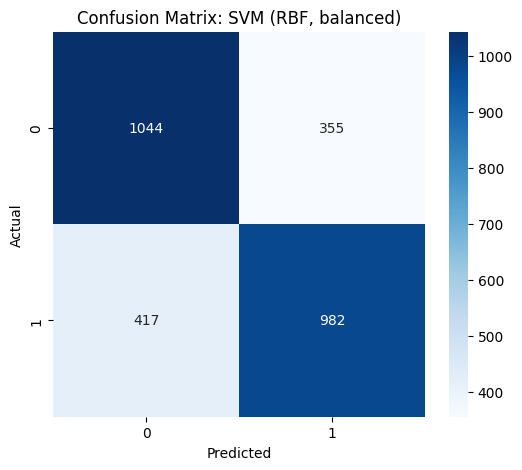


📋 Classification Report: SVM (RBF, balanced)
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1399
           1       0.73      0.70      0.72      1399

    accuracy                           0.72      2798
   macro avg       0.72      0.72      0.72      2798
weighted avg       0.72      0.72      0.72      2798


✅ Модель и scaler сохранены в: /content/drive/MyDrive/K_means/texts_for_classificator/split//models


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# === Пути ===
base_path = "/content/drive/MyDrive/K_means/texts_for_classificator/split/"
train_csv = f"{base_path}/features_train_k_means.csv"
test_csv = f"{base_path}/features_test_k_means.csv"
model_output_path = f"{base_path}/models"
os.makedirs(model_output_path, exist_ok=True)

# === Загрузка данных ===
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# drop_cols = ["text_id", "filename", "bot", "human", "cluster_distribution", "uniqueness_ratio"]
selected_features = ['min_inter']
X_train = train_df[selected_features].values
y_train = train_df["bot"].values
X_test = test_df[selected_features].values
y_test = test_df["bot"].values

# === Масштабирование ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Классификаторы ===
models = {
    "Linear SVC (balanced)": LinearSVC(max_iter=10000, class_weight="balanced"),
    "SVM (RBF, balanced)": SVC(kernel="rbf", class_weight="balanced"),
    "Decision Tree (balanced)": DecisionTreeClassifier(class_weight="balanced"),
    "Random Forest (balanced)": RandomForestClassifier(class_weight="balanced")
}

results = []
predictions = {}
trained_models = {}

# === Кросс-валидация ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    acc_scores = []
    f1_scores = []

    print(f"\n📌 Модель: {name}")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train), 1):
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_fold_train, y_fold_train)
        y_val_pred = model.predict(X_fold_val)

        acc_scores.append(accuracy_score(y_fold_val, y_val_pred))
        f1_scores.append(f1_score(y_fold_val, y_val_pred))

        print(f"Фолд {fold}: Accuracy = {acc_scores[-1]:.3f}, F1 = {f1_scores[-1]:.3f}")

    # Обучаем на всей обучающей выборке
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    y_test_pred = model.predict(X_test_scaled)
    predictions[name] = y_test_pred

    results.append({
        "Model": name,
        "CV Accuracy": np.mean(acc_scores),
        "CV F1 Score": np.mean(f1_scores),
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Test F1 Score": f1_score(y_test, y_test_pred),
        "Precision (Bot)": classification_report(y_test, y_test_pred, output_dict=True)["1"]["precision"],
        "Recall (Bot)": classification_report(y_test, y_test_pred, output_dict=True)["1"]["recall"]
    })

# === Результаты ===
results_df = pd.DataFrame(results).sort_values(by="Test F1 Score", ascending=False)
print("\n📊 Сравнение моделей:")
print(results_df)

# === Матрица ошибок для лучшей модели ===
best_model_name = results_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]
y_best = predictions[best_model_name]

conf_matrix = confusion_matrix(y_test, y_best)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

print(f"\n📋 Classification Report: {best_model_name}")
print(classification_report(y_test, y_best))

# === Сохранение лучшей модели ===
model_path = os.path.join(model_output_path, f"best_model_cv_{best_model_name.replace(' ', '_').lower()}.pkl")
scaler_path = os.path.join(model_output_path, "scaler.pkl")
joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"\n✅ Модель и scaler сохранены в: {model_output_path}")
